In [2]:
import torch
import os
import numpy as np
import pandas as pd
import diffusers
import shutil
import matplotlib.pyplot as plt
from torch.optim import AdamW
from diffusers import DiffusionPipeline
from diffusers import StableDiffusionPipeline
from peft import get_peft_model, LoraConfig
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPModel, CLIPProcessor
from transformers import AutoModel, AutoTokenizer, CLIPProcessor, CLIPModel
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline, AutoencoderKL
from sklearn.metrics import f1_score, recall_score
from PIL import Image
from tqdm import tqdm

NORMAL:1349
BACTERIA:2538
VIRUS:1345


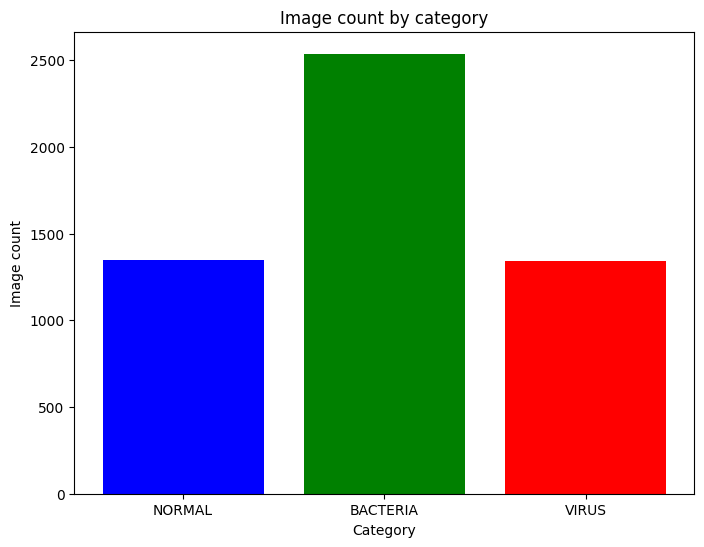

In [3]:
#Import and visualize data
normal_dir='/data3/maowenfei/chest_xray/train/NORMAL'
pneumonia_dir='/data3/maowenfei/chest_xray/train/PNEUMONIA'

#Count the number of images in the NORMAL category
normal_count = len([f for f in os.listdir(normal_dir) if f.endswith('.jpeg')])
#Count the number of images in the BACTERIA and VIRUS category
bacteria_count = len([f for f in os.listdir(pneumonia_dir) if f.startswith('BACTERIA') and f.endswith('.jpeg')])
virus_count = len([f for f in os.listdir(pneumonia_dir) if f.startswith('VIRUS') and f.endswith('.jpeg')])

#Export the result
print(f"NORMAL:{normal_count}")
print(f"BACTERIA:{bacteria_count}")
print(f"VIRUS:{virus_count}")

#Make the plot
categoris=['NORMAL','BACTERIA','VIRUS']
counts=[normal_count, bacteria_count, virus_count]
plt.figure(figsize=(8,6))
plt.bar(categoris, counts, color = ['blue', 'green', 'red'])
plt.xlabel('Category')
plt.ylabel('Image count')
plt.title('Image count by category')
plt.show()

In [3]:
# deploy the stable diffusion model locally
model_path = "/data3/maowenfei/stabilityaistable-diffusion-2"
pipeline = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
#Fine-tune the stable diffusion model by using normal chest X-ray images
#Define data class
class ChestXrayDataset(Dataset):
    def __init__(self, image_dir, tokenizer, prompt="An image of normal chest X-ray "):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(".jpeg")]
        self.prompt = prompt
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image = image.resize((512, 512))

        image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0
        image.requires_grad = True 

        text_inputs = self.tokenizer(self.prompt, return_tensors="pt", padding="max_length", max_length=77, truncation=True)

        return {"pixel_values": image, "input_ids": text_inputs.input_ids[0]}

model_path = "/data3/maowenfei/stabilityaistable-diffusion-2"
image_dir = "/data3/maowenfei/chest_xray/train/NORMAL"

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
pipeline = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16, use_flash_attention=False)
device = torch.device("cuda:3")
pipeline = pipeline.to(device)

# Define LoRA configuration 
lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["attn", "proj_in"],
    lora_dropout=0.1,
    bias="none",
)

# Apply LoRA fine-tuning to unet
pipeline.unet = get_peft_model(pipeline.unet, lora_config)

# Dataset and DataLoader setup
dataset = ChestXrayDataset(image_dir=image_dir, tokenizer=tokenizer)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
optimizer = torch.optim.AdamW(pipeline.unet.parameters(), lr=1e-4)

num_epochs = 1  
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)

        prompts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

        with torch.no_grad():
            generated_images = pipeline(prompt=prompts, pixel_values=pixel_values).images

        generated_images_tensor = torch.stack(
            [torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.0 for img in generated_images]
        ).to(device)

        if generated_images_tensor.size(2) != pixel_values.size(2) or generated_images_tensor.size(3) != pixel_values.size(3):
            generated_images_tensor = torch.nn.functional.interpolate(
                generated_images_tensor, size=(pixel_values.size(2), pixel_values.size(3)), mode='bilinear', align_corners=False
            )

        loss = torch.nn.functional.mse_loss(generated_images_tensor, pixel_values)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    average_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1} completed. Average Loss: {average_loss}")

pipeline.save_pretrained("/data3/maowenfei/stabilityaistable-diffusion-2-finetuned-lora-normal")  # save the fine-tuned model
torch.save(pipeline.unet.state_dict(), '/data3/maowenfei/stabilityaistable-diffusion-2-finetuned-lora-normal/unet.pth')  # save the fine-tuned unet path

Keyword arguments {'use_flash_attention': False} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Training Epoch 1/1:   0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   0%|          | 1/338 [00:30<2:50:17, 30.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   1%|          | 2/338 [00:49<2:11:36, 23.50s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   1%|          | 3/338 [01:08<1:59:43, 21.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   1%|          | 4/338 [01:27<1:54:54, 20.64s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   1%|▏         | 5/338 [01:46<1:51:59, 20.18s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   2%|▏         | 6/338 [02:06<1:49:58, 19.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   2%|▏         | 7/338 [02:25<1:48:42, 19.71s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   2%|▏         | 8/338 [02:44<1:46:56, 19.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   3%|▎         | 9/338 [03:04<1:47:07, 19.54s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   3%|▎         | 10/338 [03:23<1:46:06, 19.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   3%|▎         | 11/338 [03:42<1:45:10, 19.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   4%|▎         | 12/338 [04:01<1:44:49, 19.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   4%|▍         | 13/338 [04:20<1:44:46, 19.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   4%|▍         | 14/338 [04:40<1:44:42, 19.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   4%|▍         | 15/338 [04:59<1:44:13, 19.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   5%|▍         | 16/338 [05:18<1:43:18, 19.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   5%|▌         | 17/338 [05:38<1:43:03, 19.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   5%|▌         | 18/338 [05:57<1:42:16, 19.18s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   6%|▌         | 19/338 [06:16<1:41:54, 19.17s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   6%|▌         | 20/338 [06:35<1:42:05, 19.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   6%|▌         | 21/338 [06:55<1:42:09, 19.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   7%|▋         | 22/338 [07:14<1:41:40, 19.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   7%|▋         | 23/338 [07:33<1:41:46, 19.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   7%|▋         | 24/338 [07:53<1:41:08, 19.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   7%|▋         | 25/338 [08:12<1:40:21, 19.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   8%|▊         | 26/338 [08:31<1:39:36, 19.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   8%|▊         | 27/338 [08:50<1:38:56, 19.09s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   8%|▊         | 28/338 [09:09<1:38:51, 19.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   9%|▊         | 29/338 [09:28<1:39:06, 19.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   9%|▉         | 30/338 [09:48<1:39:18, 19.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   9%|▉         | 31/338 [10:08<1:39:30, 19.45s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   9%|▉         | 32/338 [10:27<1:39:03, 19.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  10%|▉         | 33/338 [10:46<1:38:09, 19.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  10%|█         | 34/338 [11:05<1:37:27, 19.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  10%|█         | 35/338 [11:24<1:36:53, 19.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  11%|█         | 36/338 [11:43<1:36:14, 19.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  11%|█         | 37/338 [12:03<1:36:27, 19.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  11%|█         | 38/338 [12:22<1:36:33, 19.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  12%|█▏        | 39/338 [12:42<1:36:21, 19.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  12%|█▏        | 40/338 [13:01<1:36:15, 19.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  12%|█▏        | 41/338 [13:20<1:35:49, 19.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  12%|█▏        | 42/338 [13:39<1:35:09, 19.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  13%|█▎        | 43/338 [13:59<1:34:54, 19.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  13%|█▎        | 44/338 [14:18<1:34:00, 19.18s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  13%|█▎        | 45/338 [14:37<1:34:05, 19.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  14%|█▎        | 46/338 [14:57<1:34:18, 19.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  14%|█▍        | 47/338 [15:16<1:34:11, 19.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  14%|█▍        | 48/338 [15:36<1:33:45, 19.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  14%|█▍        | 49/338 [15:55<1:33:20, 19.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  15%|█▍        | 50/338 [16:14<1:32:15, 19.22s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  15%|█▌        | 51/338 [16:33<1:32:04, 19.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  15%|█▌        | 52/338 [16:52<1:31:43, 19.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  16%|█▌        | 53/338 [17:12<1:31:17, 19.22s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  16%|█▌        | 54/338 [17:31<1:31:17, 19.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  16%|█▋        | 55/338 [17:50<1:31:07, 19.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  17%|█▋        | 56/338 [18:10<1:31:12, 19.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  17%|█▋        | 57/338 [18:29<1:30:55, 19.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  17%|█▋        | 58/338 [18:49<1:30:43, 19.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  17%|█▋        | 59/338 [19:08<1:29:52, 19.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  18%|█▊        | 60/338 [19:27<1:29:11, 19.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  18%|█▊        | 61/338 [19:46<1:28:34, 19.18s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  18%|█▊        | 62/338 [20:06<1:28:41, 19.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  19%|█▊        | 63/338 [20:25<1:28:11, 19.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  19%|█▉        | 64/338 [20:44<1:28:03, 19.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  19%|█▉        | 65/338 [21:04<1:28:15, 19.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  20%|█▉        | 66/338 [21:23<1:27:49, 19.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  20%|█▉        | 67/338 [21:42<1:26:47, 19.22s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  20%|██        | 68/338 [22:01<1:26:42, 19.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  20%|██        | 69/338 [22:20<1:26:06, 19.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  21%|██        | 70/338 [22:40<1:25:50, 19.22s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  21%|██        | 71/338 [22:59<1:25:50, 19.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  21%|██▏       | 72/338 [23:19<1:25:50, 19.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  22%|██▏       | 73/338 [23:38<1:25:45, 19.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  22%|██▏       | 74/338 [23:58<1:25:29, 19.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  22%|██▏       | 75/338 [24:17<1:24:26, 19.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  22%|██▏       | 76/338 [24:36<1:24:07, 19.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  23%|██▎       | 77/338 [24:55<1:23:40, 19.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  23%|██▎       | 78/338 [25:14<1:23:03, 19.17s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  23%|██▎       | 79/338 [25:33<1:23:11, 19.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  24%|██▎       | 80/338 [25:53<1:22:52, 19.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  24%|██▍       | 81/338 [26:12<1:22:48, 19.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  24%|██▍       | 82/338 [26:32<1:23:01, 19.46s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  25%|██▍       | 83/338 [26:51<1:22:20, 19.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  25%|██▍       | 84/338 [27:10<1:21:44, 19.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  25%|██▌       | 85/338 [27:30<1:21:47, 19.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  25%|██▌       | 86/338 [27:49<1:21:04, 19.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  26%|██▌       | 87/338 [28:08<1:20:16, 19.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  26%|██▌       | 88/338 [28:27<1:20:06, 19.22s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  26%|██▋       | 89/338 [28:46<1:19:11, 19.08s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  27%|██▋       | 90/338 [29:05<1:18:29, 18.99s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  27%|██▋       | 91/338 [29:24<1:18:02, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  27%|██▋       | 92/338 [29:43<1:17:38, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  28%|██▊       | 93/338 [30:02<1:17:23, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  28%|██▊       | 94/338 [30:20<1:16:56, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  28%|██▊       | 95/338 [30:39<1:16:38, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  28%|██▊       | 96/338 [30:58<1:16:23, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  29%|██▊       | 97/338 [31:17<1:16:12, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  29%|██▉       | 98/338 [31:36<1:15:39, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  29%|██▉       | 99/338 [31:55<1:15:14, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  30%|██▉       | 100/338 [32:14<1:14:59, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  30%|██▉       | 101/338 [32:33<1:14:36, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  30%|███       | 102/338 [32:52<1:14:21, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  30%|███       | 103/338 [33:11<1:14:20, 18.98s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  31%|███       | 104/338 [33:30<1:13:56, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  31%|███       | 105/338 [33:49<1:13:35, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  31%|███▏      | 106/338 [34:08<1:13:15, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  32%|███▏      | 107/338 [34:26<1:12:50, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  32%|███▏      | 108/338 [34:45<1:12:28, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  32%|███▏      | 109/338 [35:04<1:12:20, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  33%|███▎      | 110/338 [35:23<1:12:06, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  33%|███▎      | 111/338 [35:42<1:11:48, 18.98s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  33%|███▎      | 112/338 [36:01<1:11:35, 19.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  33%|███▎      | 113/338 [36:20<1:10:59, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  34%|███▎      | 114/338 [36:39<1:10:42, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  34%|███▍      | 115/338 [36:58<1:10:15, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  34%|███▍      | 116/338 [37:17<1:10:10, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  35%|███▍      | 117/338 [37:36<1:09:52, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  35%|███▍      | 118/338 [37:55<1:09:33, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  35%|███▌      | 119/338 [38:14<1:09:05, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  36%|███▌      | 120/338 [38:33<1:08:44, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  36%|███▌      | 121/338 [38:52<1:08:21, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  36%|███▌      | 122/338 [39:11<1:08:01, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  36%|███▋      | 123/338 [39:29<1:07:43, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  37%|███▋      | 124/338 [39:48<1:07:27, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  37%|███▋      | 125/338 [40:07<1:07:13, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  37%|███▋      | 126/338 [40:26<1:06:50, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  38%|███▊      | 127/338 [40:45<1:06:30, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  38%|███▊      | 128/338 [41:04<1:06:08, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  38%|███▊      | 129/338 [41:23<1:05:45, 18.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  38%|███▊      | 130/338 [41:42<1:05:41, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  39%|███▉      | 131/338 [42:01<1:05:29, 18.98s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  39%|███▉      | 132/338 [42:20<1:05:11, 18.99s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  39%|███▉      | 133/338 [42:39<1:04:48, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  40%|███▉      | 134/338 [42:58<1:04:16, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  40%|███▉      | 135/338 [43:17<1:03:52, 18.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  40%|████      | 136/338 [43:35<1:03:22, 18.82s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  41%|████      | 137/338 [43:54<1:03:07, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  41%|████      | 138/338 [44:13<1:03:01, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  41%|████      | 139/338 [44:32<1:03:00, 19.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  41%|████▏     | 140/338 [44:51<1:02:34, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  42%|████▏     | 141/338 [45:10<1:02:11, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  42%|████▏     | 142/338 [45:29<1:01:40, 18.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  42%|████▏     | 143/338 [45:48<1:01:10, 18.82s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  43%|████▎     | 144/338 [46:07<1:01:02, 18.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  43%|████▎     | 145/338 [46:25<1:00:43, 18.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  43%|████▎     | 146/338 [46:45<1:00:36, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  43%|████▎     | 147/338 [47:03<1:00:15, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  44%|████▍     | 148/338 [47:22<59:53, 18.91s/it]  

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  44%|████▍     | 149/338 [47:41<59:22, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  44%|████▍     | 150/338 [48:00<58:53, 18.80s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  45%|████▍     | 151/338 [48:19<58:37, 18.81s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  45%|████▍     | 152/338 [48:38<58:27, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  45%|████▌     | 153/338 [48:56<58:13, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  46%|████▌     | 154/338 [49:15<57:51, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  46%|████▌     | 155/338 [49:34<57:33, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  46%|████▌     | 156/338 [49:53<57:08, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  46%|████▋     | 157/338 [50:12<56:44, 18.81s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  47%|████▋     | 158/338 [50:30<56:24, 18.80s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  47%|████▋     | 159/338 [50:49<56:14, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  47%|████▋     | 160/338 [51:08<55:54, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  48%|████▊     | 161/338 [51:27<55:40, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  48%|████▊     | 162/338 [51:46<55:18, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  48%|████▊     | 163/338 [52:05<54:53, 18.82s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  49%|████▊     | 164/338 [52:24<54:35, 18.82s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  49%|████▉     | 165/338 [52:42<54:14, 18.81s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  49%|████▉     | 166/338 [53:01<54:07, 18.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  49%|████▉     | 167/338 [53:20<53:56, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  50%|████▉     | 168/338 [53:40<53:45, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  50%|█████     | 169/338 [53:58<53:20, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  50%|█████     | 170/338 [54:17<52:53, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  51%|█████     | 171/338 [54:36<52:33, 18.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  51%|█████     | 172/338 [54:55<52:08, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  51%|█████     | 173/338 [55:14<51:57, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  51%|█████▏    | 174/338 [55:33<51:42, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  52%|█████▏    | 175/338 [55:52<51:20, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  52%|█████▏    | 176/338 [56:10<50:55, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  52%|█████▏    | 177/338 [56:29<50:37, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  53%|█████▎    | 178/338 [56:48<50:28, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  53%|█████▎    | 179/338 [57:07<49:58, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  53%|█████▎    | 180/338 [57:26<49:50, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  54%|█████▎    | 181/338 [57:45<49:34, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  54%|█████▍    | 182/338 [58:04<49:19, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  54%|█████▍    | 183/338 [58:23<48:55, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  54%|█████▍    | 184/338 [58:42<48:29, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  55%|█████▍    | 185/338 [59:01<48:11, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  55%|█████▌    | 186/338 [59:20<47:52, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  55%|█████▌    | 187/338 [59:39<47:43, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  56%|█████▌    | 188/338 [59:58<47:23, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  56%|█████▌    | 189/338 [1:00:16<46:58, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  56%|█████▌    | 190/338 [1:00:35<46:38, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  57%|█████▋    | 191/338 [1:00:54<46:21, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  57%|█████▋    | 192/338 [1:01:13<46:01, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  57%|█████▋    | 193/338 [1:01:32<45:29, 18.83s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  57%|█████▋    | 194/338 [1:01:51<45:11, 18.83s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  58%|█████▊    | 195/338 [1:02:10<45:05, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  58%|█████▊    | 196/338 [1:02:29<44:50, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  58%|█████▊    | 197/338 [1:02:48<44:38, 19.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  59%|█████▊    | 198/338 [1:03:07<44:20, 19.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  59%|█████▉    | 199/338 [1:03:26<43:56, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  59%|█████▉    | 200/338 [1:03:45<43:28, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  59%|█████▉    | 201/338 [1:04:03<43:10, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  60%|█████▉    | 202/338 [1:04:23<42:58, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  60%|██████    | 203/338 [1:04:41<42:36, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  60%|██████    | 204/338 [1:05:00<42:12, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  61%|██████    | 205/338 [1:05:19<41:45, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  61%|██████    | 206/338 [1:05:38<41:22, 18.81s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  61%|██████    | 207/338 [1:05:56<41:02, 18.80s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  62%|██████▏   | 208/338 [1:06:15<40:40, 18.77s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  62%|██████▏   | 209/338 [1:06:34<40:22, 18.78s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  62%|██████▏   | 210/338 [1:06:53<40:09, 18.82s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  62%|██████▏   | 211/338 [1:07:12<39:55, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  63%|██████▎   | 212/338 [1:07:31<39:41, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  63%|██████▎   | 213/338 [1:07:50<39:22, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  63%|██████▎   | 214/338 [1:08:09<39:06, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  64%|██████▎   | 215/338 [1:08:28<38:49, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  64%|██████▍   | 216/338 [1:08:47<38:34, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  64%|██████▍   | 217/338 [1:09:06<38:11, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  64%|██████▍   | 218/338 [1:09:25<37:51, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  65%|██████▍   | 219/338 [1:09:43<37:30, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  65%|██████▌   | 220/338 [1:10:02<37:09, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  65%|██████▌   | 221/338 [1:10:21<36:56, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  66%|██████▌   | 222/338 [1:10:40<36:35, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  66%|██████▌   | 223/338 [1:10:59<36:18, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  66%|██████▋   | 224/338 [1:11:18<36:02, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  67%|██████▋   | 225/338 [1:11:37<35:42, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  67%|██████▋   | 226/338 [1:11:56<35:21, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  67%|██████▋   | 227/338 [1:12:15<34:55, 18.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  67%|██████▋   | 228/338 [1:12:34<34:38, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  68%|██████▊   | 229/338 [1:12:52<34:13, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  68%|██████▊   | 230/338 [1:13:11<33:58, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  68%|██████▊   | 231/338 [1:13:30<33:44, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  69%|██████▊   | 232/338 [1:13:49<33:27, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  69%|██████▉   | 233/338 [1:14:08<33:04, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  69%|██████▉   | 234/338 [1:14:27<32:41, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  70%|██████▉   | 235/338 [1:14:46<32:24, 18.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  70%|██████▉   | 236/338 [1:15:05<32:07, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  70%|███████   | 237/338 [1:15:24<31:55, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  70%|███████   | 238/338 [1:15:43<31:38, 18.99s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  71%|███████   | 239/338 [1:16:02<31:21, 19.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  71%|███████   | 240/338 [1:16:21<30:59, 18.98s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  71%|███████▏  | 241/338 [1:16:40<30:37, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  72%|███████▏  | 242/338 [1:16:59<30:19, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  72%|███████▏  | 243/338 [1:17:18<30:01, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  72%|███████▏  | 244/338 [1:17:37<29:42, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  72%|███████▏  | 245/338 [1:17:56<29:22, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  73%|███████▎  | 246/338 [1:18:15<29:03, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  73%|███████▎  | 247/338 [1:18:33<28:37, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  73%|███████▎  | 248/338 [1:18:52<28:20, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  74%|███████▎  | 249/338 [1:19:11<28:04, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  74%|███████▍  | 250/338 [1:19:30<27:46, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  74%|███████▍  | 251/338 [1:19:49<27:25, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  75%|███████▍  | 252/338 [1:20:08<27:09, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  75%|███████▍  | 253/338 [1:20:27<26:52, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  75%|███████▌  | 254/338 [1:20:46<26:31, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  75%|███████▌  | 255/338 [1:21:05<26:09, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  76%|███████▌  | 256/338 [1:21:24<25:49, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  76%|███████▌  | 257/338 [1:21:43<25:34, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  76%|███████▋  | 258/338 [1:22:02<25:15, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  77%|███████▋  | 259/338 [1:22:21<24:55, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  77%|███████▋  | 260/338 [1:22:40<24:36, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  77%|███████▋  | 261/338 [1:22:59<24:20, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  78%|███████▊  | 262/338 [1:23:17<23:57, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  78%|███████▊  | 263/338 [1:23:36<23:36, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  78%|███████▊  | 264/338 [1:23:55<23:16, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  78%|███████▊  | 265/338 [1:24:14<22:53, 18.82s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  79%|███████▊  | 266/338 [1:24:33<22:37, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  79%|███████▉  | 267/338 [1:24:52<22:19, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  79%|███████▉  | 268/338 [1:25:10<21:56, 18.81s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  80%|███████▉  | 269/338 [1:25:29<21:34, 18.76s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  80%|███████▉  | 270/338 [1:25:48<21:19, 18.82s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  80%|████████  | 271/338 [1:26:07<21:00, 18.81s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  80%|████████  | 272/338 [1:26:25<20:40, 18.79s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  81%|████████  | 273/338 [1:26:44<20:25, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  81%|████████  | 274/338 [1:27:03<20:11, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  81%|████████▏ | 275/338 [1:27:22<19:50, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  82%|████████▏ | 276/338 [1:27:41<19:28, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  82%|████████▏ | 277/338 [1:28:00<19:12, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  82%|████████▏ | 278/338 [1:28:19<18:51, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  83%|████████▎ | 279/338 [1:28:38<18:30, 18.83s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  83%|████████▎ | 280/338 [1:28:56<18:14, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  83%|████████▎ | 281/338 [1:29:15<17:56, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  83%|████████▎ | 282/338 [1:29:34<17:40, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  84%|████████▎ | 283/338 [1:29:53<17:18, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  84%|████████▍ | 284/338 [1:30:12<17:00, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  84%|████████▍ | 285/338 [1:30:31<16:41, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  85%|████████▍ | 286/338 [1:30:50<16:22, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  85%|████████▍ | 287/338 [1:31:09<16:04, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  85%|████████▌ | 288/338 [1:31:28<15:51, 19.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  86%|████████▌ | 289/338 [1:31:47<15:32, 19.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  86%|████████▌ | 290/338 [1:32:06<15:11, 18.99s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  86%|████████▌ | 291/338 [1:32:25<14:49, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  86%|████████▋ | 292/338 [1:32:44<14:29, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  87%|████████▋ | 293/338 [1:33:03<14:08, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  87%|████████▋ | 294/338 [1:33:21<13:48, 18.83s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  87%|████████▋ | 295/338 [1:33:40<13:29, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  88%|████████▊ | 296/338 [1:33:59<13:11, 18.83s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  88%|████████▊ | 297/338 [1:34:18<12:52, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  88%|████████▊ | 298/338 [1:34:37<12:33, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  88%|████████▊ | 299/338 [1:34:56<12:16, 18.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  89%|████████▉ | 300/338 [1:35:15<12:00, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  89%|████████▉ | 301/338 [1:35:34<11:41, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  89%|████████▉ | 302/338 [1:35:53<11:23, 18.98s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  90%|████████▉ | 303/338 [1:36:12<11:03, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  90%|████████▉ | 304/338 [1:36:31<10:45, 18.98s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  90%|█████████ | 305/338 [1:36:50<10:27, 19.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  91%|█████████ | 306/338 [1:37:08<10:04, 18.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  91%|█████████ | 307/338 [1:37:27<09:44, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  91%|█████████ | 308/338 [1:37:46<09:23, 18.79s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  91%|█████████▏| 309/338 [1:38:05<09:05, 18.83s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  92%|█████████▏| 310/338 [1:38:24<08:47, 18.83s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  92%|█████████▏| 311/338 [1:38:42<08:27, 18.81s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  92%|█████████▏| 312/338 [1:39:01<08:09, 18.83s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  93%|█████████▎| 313/338 [1:39:20<07:49, 18.80s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  93%|█████████▎| 314/338 [1:39:39<07:31, 18.83s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  93%|█████████▎| 315/338 [1:39:58<07:15, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  93%|█████████▎| 316/338 [1:40:17<06:56, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  94%|█████████▍| 317/338 [1:40:36<06:37, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  94%|█████████▍| 318/338 [1:40:55<06:18, 18.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  94%|█████████▍| 319/338 [1:41:14<05:58, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  95%|█████████▍| 320/338 [1:41:32<05:39, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  95%|█████████▍| 321/338 [1:41:51<05:20, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  95%|█████████▌| 322/338 [1:42:10<05:01, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  96%|█████████▌| 323/338 [1:42:29<04:42, 18.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  96%|█████████▌| 324/338 [1:42:48<04:23, 18.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  96%|█████████▌| 325/338 [1:43:07<04:05, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  96%|█████████▋| 326/338 [1:43:26<03:46, 18.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  97%|█████████▋| 327/338 [1:43:44<03:27, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  97%|█████████▋| 328/338 [1:44:03<03:08, 18.82s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  97%|█████████▋| 329/338 [1:44:22<02:49, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  98%|█████████▊| 330/338 [1:44:41<02:30, 18.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  98%|█████████▊| 331/338 [1:45:00<02:12, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  98%|█████████▊| 332/338 [1:45:19<01:53, 19.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  99%|█████████▊| 333/338 [1:45:38<01:34, 18.98s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  99%|█████████▉| 334/338 [1:45:57<01:15, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  99%|█████████▉| 335/338 [1:46:16<00:56, 18.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  99%|█████████▉| 336/338 [1:46:35<00:37, 18.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1: 100%|█████████▉| 337/338 [1:46:54<00:18, 18.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1: 100%|██████████| 338/338 [1:47:00<00:00, 18.99s/it]


Epoch 1 completed. Average Loss: 0.10090945566282469


self.unet=PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): lora.Linear(
                (base_layer): Linear(in_features=320, out_features=320, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=320, out_features=4, bias=False)
        

Fine-tuning with LoRA completed and model saved.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_831002/2417398313.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_state_dict = torch.load(f"{finetuned_model_path}/unet.pth", map_location=device)


  0%|          | 0/50 [00:00<?, ?it/s]

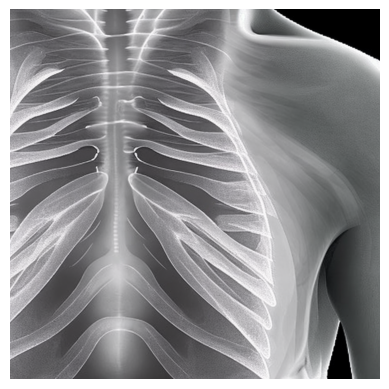

In [ ]:
# show the synthetic normal chest xray image by using fine-tuned stable diffusion model
device = torch.device("cuda:3")
model_path = "/data3/maowenfei/stabilityaistable-diffusion-2"
finetuned_model_path = "/data3/maowenfei/stabilityaistable-diffusion-2-finetuned-lora-normal"
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)

unet_state_dict = torch.load(f"{finetuned_model_path}/unet.pth", map_location=device)
pipe.unet.load_state_dict(unet_state_dict, strict=False) 
del unet_state_dict   # free GPU memory
pipe = pipe.to(device)
prompt = "An image of normal chest X-ray"

In [ ]:
#Generated 1000 synthetic normal chest xray image
#load the model path and fine-tuned model path
device = torch.device("cuda:3")
model_path = "/data3/maowenfei/stabilityaistable-diffusion-2"
finetuned_model_path = "/data3/maowenfei/stabilityaistable-diffusion-2-finetuned-lora-normal"

#load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16 
)

#load the fine-tuned U-Net and delete the unet variable to free GPU memory
unet_state_dict = torch.load(f"{finetuned_model_path}/unet.pth", map_location=device)
pipe.unet.load_state_dict(unet_state_dict, strict=False) 
del unet_state_dict   # free GPU memory
pipe = pipe.to(device)
output_dir = "generated_normal_images"
os.makedirs(output_dir, exist_ok=True)

# Prompts to generate images
prompt = "An image of normal chest X-ray"

#Generated 1000 images
for i in range(1000):
    image = pipe(prompt).images[0]
    image.save(f"{output_dir}/generated_normal_image_{i+1}.jpeg", format="JPEG")
    print(f"Generated {i+1} images.")
    
# Free the GPU memory
    del image
    torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_831002/225673927.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_state_dict = torch.load(f"{finetuned_model_path}/unet.pth", map_location=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 1 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 2 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 3 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 4 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 5 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 6 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 7 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 8 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 9 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 10 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 11 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 12 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 13 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 14 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 15 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 16 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 17 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 18 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 19 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 20 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 21 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 22 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 23 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 24 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 25 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 26 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 27 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 28 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 29 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 30 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 31 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 32 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 33 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 34 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 35 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 36 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 37 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 38 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 39 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 40 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 41 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 42 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 43 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 44 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 45 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 46 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 47 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 48 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 49 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 50 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 51 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 52 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 53 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 54 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 55 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 56 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 57 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 58 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 59 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 60 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 61 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 62 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 63 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 64 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 65 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 66 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 67 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 68 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 69 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 70 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 71 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 72 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 73 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 74 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 75 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 76 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 77 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 78 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 79 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 80 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 81 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 82 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 83 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 84 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 85 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 86 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 87 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 88 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 89 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 90 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 91 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 92 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 93 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 94 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 95 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 96 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 97 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 98 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 99 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 100 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 101 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 102 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 103 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 104 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 105 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 106 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 107 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 108 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 109 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 110 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 111 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 112 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 113 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 114 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 115 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 116 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 117 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 118 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 119 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 120 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 121 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 122 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 123 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 124 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 125 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 126 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 127 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 128 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 129 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 130 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 131 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 132 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 133 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 134 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 135 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 136 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 137 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 138 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 139 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 140 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 141 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 142 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 143 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 144 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 145 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 146 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 147 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 148 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 149 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 150 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 151 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 152 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 153 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 154 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 155 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 156 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 157 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 158 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 159 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 160 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 161 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 162 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 163 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 164 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 165 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 166 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 167 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 168 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 169 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 170 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 171 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 172 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 173 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 174 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 175 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 176 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 177 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 178 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 179 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 180 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 181 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 182 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 183 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 184 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 185 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 186 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 187 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 188 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 189 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 190 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 191 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 192 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 193 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 194 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 195 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 196 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 197 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 198 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 199 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 200 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 201 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 202 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 203 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 204 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 205 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 206 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 207 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 208 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 209 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 210 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 211 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 212 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 213 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 214 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 215 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 216 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 217 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 218 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 219 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 220 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 221 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 222 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 223 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 224 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 225 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 226 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 227 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 228 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 229 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 230 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 231 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 232 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 233 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 234 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 235 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 236 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 237 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 238 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 239 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 240 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 241 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 242 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 243 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 244 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 245 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 246 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 247 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 248 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 249 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 250 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 251 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 252 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 253 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 254 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 255 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 256 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 257 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 258 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 259 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 260 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 261 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 262 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 263 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 264 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 265 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 266 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 267 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 268 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 269 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 270 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 271 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 272 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 273 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 274 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 275 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 276 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 277 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 278 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 279 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 280 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 281 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 282 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 283 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 284 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 285 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 286 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 287 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 288 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 289 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 290 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 291 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 292 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 293 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 294 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 295 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 296 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 297 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 298 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 299 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 300 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 301 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 302 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 303 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 304 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 305 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 306 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 307 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 308 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 309 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 310 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 311 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 312 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 313 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 314 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 315 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 316 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 317 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 318 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 319 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 320 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 321 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 322 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 323 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 324 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 325 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 326 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 327 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 328 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 329 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 330 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 331 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 332 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 333 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 334 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 335 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 336 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 337 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 338 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 339 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 340 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 341 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 342 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 343 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 344 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 345 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 346 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 347 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 348 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 349 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 350 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 351 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 352 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 353 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 354 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 355 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 356 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 357 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 358 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 359 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 360 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 361 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 362 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 363 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 364 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 365 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 366 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 367 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 368 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 369 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 370 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 371 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 372 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 373 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 374 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 375 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 376 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 377 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 378 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 379 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 380 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 381 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 382 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 383 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 384 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 385 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 386 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 387 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 388 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 389 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 390 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 391 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 392 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 393 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 394 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 395 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 396 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 397 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 398 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 399 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 400 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 401 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 402 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 403 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 404 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 405 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 406 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 407 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 408 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 409 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 410 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 411 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 412 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 413 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 414 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 415 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 416 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 417 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 418 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 419 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 420 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 421 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 422 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 423 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 424 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 425 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 426 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 427 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 428 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 429 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 430 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 431 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 432 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 433 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 434 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 435 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 436 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 437 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 438 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 439 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 440 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 441 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 442 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 443 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 444 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 445 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 446 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 447 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 448 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 449 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 450 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 451 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 452 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 453 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 454 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 455 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 456 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 457 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 458 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 459 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 460 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 461 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 462 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 463 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 464 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 465 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 466 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 467 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 468 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 469 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 470 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 471 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 472 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 473 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 474 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 475 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 476 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 477 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 478 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 479 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 480 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 481 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 482 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 483 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 484 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 485 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 486 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 487 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 488 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 489 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 490 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 491 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 492 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 493 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 494 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 495 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 496 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 497 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 498 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 499 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 500 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 501 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 502 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 503 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 504 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 505 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 506 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 507 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 508 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 509 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 510 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 511 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 512 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 513 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 514 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 515 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 516 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 517 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 518 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 519 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 520 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 521 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 522 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 523 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 524 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 525 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 526 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 527 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 528 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 529 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 530 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 531 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 532 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 533 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 534 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 535 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 536 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 537 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 538 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 539 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 540 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 541 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 542 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 543 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 544 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 545 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 546 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 547 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 548 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 549 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 550 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 551 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 552 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 553 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 554 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 555 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 556 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 557 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 558 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 559 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 560 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 561 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 562 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 563 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 564 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 565 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 566 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 567 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 568 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 569 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 570 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 571 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 572 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 573 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 574 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 575 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 576 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 577 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 578 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 579 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 580 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 581 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 582 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 583 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 584 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 585 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 586 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 587 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 588 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 589 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 590 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 591 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 592 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 593 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 594 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 595 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 596 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 597 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 598 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 599 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 600 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 601 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 602 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 603 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 604 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 605 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 606 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 607 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 608 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 609 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 610 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 611 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 612 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 613 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 614 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 615 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 616 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 617 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 618 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 619 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 620 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 621 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 622 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 623 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 624 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 625 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 626 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 627 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 628 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 629 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 630 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 631 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 632 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 633 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 634 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 635 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 636 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 637 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 638 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 639 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 640 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 641 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 642 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 643 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 644 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 645 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 646 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 647 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 648 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 649 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 650 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 651 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 652 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 653 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 654 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 655 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 656 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 657 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 658 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 659 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 660 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 661 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 662 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 663 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 664 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 665 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 666 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 667 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 668 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 669 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 670 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 671 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 672 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 673 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 674 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 675 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 676 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 677 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 678 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 679 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 680 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 681 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 682 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 683 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 684 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 685 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 686 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 687 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 688 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 689 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 690 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 691 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 692 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 693 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 694 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 695 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 696 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 697 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 698 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 699 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 700 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 701 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 702 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 703 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 704 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 705 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 706 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 707 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 708 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 709 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 710 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 711 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 712 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 713 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 714 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 715 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 716 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 717 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 718 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 719 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 720 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 721 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 722 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 723 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 724 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 725 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 726 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 727 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 728 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 729 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 730 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 731 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 732 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 733 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 734 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 735 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 736 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 737 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 738 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 739 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 740 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 741 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 742 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 743 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 744 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 745 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 746 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 747 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 748 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 749 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 750 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 751 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 752 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 753 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 754 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 755 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 756 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 757 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 758 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 759 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 760 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 761 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 762 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 763 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 764 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 765 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 766 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 767 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 768 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 769 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 770 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 771 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 772 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 773 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 774 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 775 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 776 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 777 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 778 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 779 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 780 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 781 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 782 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 783 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 784 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 785 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 786 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 787 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 788 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 789 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 790 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 791 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 792 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 793 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 794 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 795 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 796 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 797 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 798 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 799 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 800 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 801 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 802 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 803 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 804 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 805 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 806 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 807 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 808 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 809 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 810 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 811 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 812 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 813 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 814 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 815 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 816 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 817 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 818 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 819 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 820 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 821 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 822 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 823 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 824 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 825 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 826 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 827 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 828 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 829 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 830 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 831 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 832 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 833 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 834 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 835 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 836 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 837 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 838 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 839 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 840 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 841 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 842 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 843 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 844 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 845 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 846 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 847 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 848 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 849 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 850 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 851 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 852 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 853 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 854 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 855 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 856 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 857 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 858 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 859 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 860 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 861 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 862 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 863 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 864 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 865 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 866 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 867 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 868 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 869 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 870 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 871 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 872 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 873 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 874 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 875 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 876 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 877 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 878 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 879 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 880 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 881 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 882 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 883 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 884 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 885 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 886 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 887 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 888 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 889 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 890 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 891 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 892 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 893 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 894 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 895 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 896 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 897 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 898 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 899 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 900 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 901 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 902 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 903 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 904 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 905 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 906 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 907 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 908 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 909 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 910 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 911 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 912 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 913 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 914 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 915 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 916 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 917 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 918 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 919 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 920 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 921 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 922 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 923 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 924 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 925 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 926 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 927 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 928 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 929 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 930 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 931 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 932 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 933 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 934 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 935 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 936 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 937 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 938 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 939 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 940 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 941 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 942 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 943 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 944 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 945 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 946 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 947 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 948 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 949 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 950 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 951 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 952 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 953 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 954 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 955 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 956 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 957 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 958 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 959 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 960 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 961 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 962 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 963 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 964 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 965 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 966 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 967 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 968 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 969 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 970 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 971 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 972 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 973 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 974 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 975 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 976 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 977 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 978 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 979 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 980 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 981 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 982 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 983 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 984 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 985 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 986 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 987 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 988 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 989 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 990 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 991 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 992 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 993 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 994 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 995 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 996 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 997 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 998 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 999 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 1000 images.


In [1]:
# Extract viral pneumonia from train dataset
source_data = '/data3/maowenfei/chest_xray/train/PNEUMONIA'
target_data = '/data3/maowenfei/chest_xray/train/VIRUS_ONLY'

os.makedirs(target_data, exist_ok=True)

for filename in os.listdir(source_data):
    if 'VIRUS' in filename:
        source_path = os.path.join(source_data, filename)
        target_path = os.path.join(target_data, filename)

        shutil.copy(source_path, target_path)
        print(f"Copied {filename} to {target_data}")

print("Extraction of VIRUS image is complete")

Copied VIRUS-8290580-0003.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-3722564-0005.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-3722564-0003.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-7564600-0007.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-7952682-0001.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-1213217-0004.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-3532677-0001.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-4003398-0002.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-6386500-0003.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-5081381-0002.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-2960250-0002.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-2603211-0001.jpeg to /data3/maowenfei/chest_xray/train/VIRUS_ONLY
Copied VIRUS-2777031-0002.jpeg to /data3/maowenfei/c

In [ ]:
# Fine-tune the stable diffusion model by using virus chest X-ray images
# Define dataset class
class ChestXrayDataset(Dataset):
    def __init__(self, image_dir, tokenizer, prompt="An image of virus chest X-ray "):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(".jpeg")]
        self.prompt = prompt
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image = image.resize((512, 512))

        image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0
        image.requires_grad = True 

        text_inputs = self.tokenizer(self.prompt, return_tensors="pt", padding="max_length", max_length=77, truncation=True)

        return {"pixel_values": image, "input_ids": text_inputs.input_ids[0]}

model_path = "/data3/maowenfei/stabilityaistable-diffusion-2"
image_dir = "/data3/maowenfei/chest_xray/train/VIRUS_ONLY"

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
pipeline = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16, use_flash_attention=False)
device = torch.device("cuda:3")
pipeline = pipeline.to(device)

# Define LoRA configuration 
lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["attn", "proj_in"],
    lora_dropout=0.1
)

# Apply LoRA fine-tuning to unet
pipeline.unet = get_peft_model(pipeline.unet, lora_config)

# Dataset and DataLoader setup
dataset = ChestXrayDataset(image_dir=image_dir, tokenizer=tokenizer)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
optimizer = torch.optim.AdamW(pipeline.unet.parameters(), lr=1e-4)

num_epochs = 1  
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)

        prompts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

        with torch.no_grad():
            generated_images = pipeline(prompt=prompts, pixel_values=pixel_values).images

        generated_images_tensor = torch.stack(
            [torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.0 for img in generated_images]
        ).to(device)

        if generated_images_tensor.size(2) != pixel_values.size(2) or generated_images_tensor.size(3) != pixel_values.size(3):
            generated_images_tensor = torch.nn.functional.interpolate(
                generated_images_tensor, size=(pixel_values.size(2), pixel_values.size(3)), mode='bilinear', align_corners=False
            )

        loss = torch.nn.functional.mse_loss(generated_images_tensor, pixel_values)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    average_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1} completed. Average Loss: {average_loss}")

pipeline.save_pretrained("/data3/maowenfei/stabilityaistable-diffusion-2-finetuned-lora-virus")   # save the fine-tuned model
torch.save(pipeline.unet.state_dict(), '/data3/maowenfei/stabilityaistable-diffusion-2-finetuned-lora-virus/unet.pth')   # save the unet path

Keyword arguments {'use_flash_attention': False} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Training Epoch 1/1:   0%|          | 0/337 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   0%|          | 1/337 [00:18<1:41:31, 18.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   1%|          | 2/337 [00:36<1:41:38, 18.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   1%|          | 3/337 [00:54<1:41:42, 18.27s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   1%|          | 4/337 [01:13<1:41:29, 18.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   1%|▏         | 5/337 [01:31<1:41:14, 18.30s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   2%|▏         | 6/337 [01:49<1:41:03, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   2%|▏         | 7/337 [02:08<1:40:47, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   2%|▏         | 8/337 [02:26<1:40:25, 18.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   3%|▎         | 9/337 [02:44<1:40:09, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   3%|▎         | 10/337 [03:03<1:39:55, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   3%|▎         | 11/337 [03:21<1:39:39, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   4%|▎         | 12/337 [03:39<1:39:16, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   4%|▍         | 13/337 [03:58<1:39:02, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   4%|▍         | 14/337 [04:16<1:38:46, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   4%|▍         | 15/337 [04:34<1:38:31, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   5%|▍         | 16/337 [04:53<1:38:15, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   5%|▌         | 17/337 [05:11<1:37:56, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   5%|▌         | 18/337 [05:29<1:37:37, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   6%|▌         | 19/337 [05:48<1:37:28, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   6%|▌         | 20/337 [06:06<1:37:06, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   6%|▌         | 21/337 [06:25<1:36:48, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   7%|▋         | 22/337 [06:43<1:36:35, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   7%|▋         | 23/337 [07:01<1:36:15, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   7%|▋         | 24/337 [07:20<1:35:49, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   7%|▋         | 25/337 [07:38<1:35:26, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   8%|▊         | 26/337 [07:56<1:35:07, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   8%|▊         | 27/337 [08:15<1:34:57, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   8%|▊         | 28/337 [08:33<1:34:35, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   9%|▊         | 29/337 [08:52<1:34:22, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   9%|▉         | 30/337 [09:10<1:33:56, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   9%|▉         | 31/337 [09:28<1:33:30, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:   9%|▉         | 32/337 [09:47<1:33:13, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  10%|▉         | 33/337 [10:05<1:32:54, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  10%|█         | 34/337 [10:23<1:32:31, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  10%|█         | 35/337 [10:42<1:32:18, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  11%|█         | 36/337 [11:00<1:32:06, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  11%|█         | 37/337 [11:18<1:31:48, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  11%|█▏        | 38/337 [11:37<1:31:37, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  12%|█▏        | 39/337 [11:55<1:31:18, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  12%|█▏        | 40/337 [12:14<1:30:58, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  12%|█▏        | 41/337 [12:32<1:30:43, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  12%|█▏        | 42/337 [12:50<1:30:25, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  13%|█▎        | 43/337 [13:09<1:30:04, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  13%|█▎        | 44/337 [13:27<1:29:42, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  13%|█▎        | 45/337 [13:45<1:29:22, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  14%|█▎        | 46/337 [14:04<1:29:07, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  14%|█▍        | 47/337 [14:22<1:28:50, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  14%|█▍        | 48/337 [14:41<1:28:32, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  15%|█▍        | 49/337 [14:59<1:28:15, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  15%|█▍        | 50/337 [15:17<1:27:52, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  15%|█▌        | 51/337 [15:36<1:27:24, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  15%|█▌        | 52/337 [15:54<1:27:09, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  16%|█▌        | 53/337 [16:12<1:26:50, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  16%|█▌        | 54/337 [16:31<1:26:30, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  16%|█▋        | 55/337 [16:49<1:26:12, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  17%|█▋        | 56/337 [17:07<1:25:59, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  17%|█▋        | 57/337 [17:26<1:25:42, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  17%|█▋        | 58/337 [17:44<1:25:20, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  18%|█▊        | 59/337 [18:02<1:25:03, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  18%|█▊        | 60/337 [18:21<1:24:44, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  18%|█▊        | 61/337 [18:39<1:24:33, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  18%|█▊        | 62/337 [18:58<1:24:13, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  19%|█▊        | 63/337 [19:16<1:24:01, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  19%|█▉        | 64/337 [19:34<1:23:44, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  19%|█▉        | 65/337 [19:53<1:23:15, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  20%|█▉        | 66/337 [20:11<1:22:53, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  20%|█▉        | 67/337 [20:29<1:22:32, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  20%|██        | 68/337 [20:48<1:22:22, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  20%|██        | 69/337 [21:06<1:22:04, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  21%|██        | 70/337 [21:25<1:21:46, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  21%|██        | 71/337 [21:43<1:21:26, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  21%|██▏       | 72/337 [22:01<1:21:03, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  22%|██▏       | 73/337 [22:20<1:20:50, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  22%|██▏       | 74/337 [22:38<1:20:25, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  22%|██▏       | 75/337 [22:56<1:20:06, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  23%|██▎       | 76/337 [23:15<1:19:48, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  23%|██▎       | 77/337 [23:33<1:19:28, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  23%|██▎       | 78/337 [23:51<1:19:16, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  23%|██▎       | 79/337 [24:10<1:18:57, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  24%|██▎       | 80/337 [24:28<1:18:39, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  24%|██▍       | 81/337 [24:46<1:18:17, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  24%|██▍       | 82/337 [25:05<1:18:00, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  25%|██▍       | 83/337 [25:23<1:17:41, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  25%|██▍       | 84/337 [25:42<1:17:49, 18.46s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  25%|██▌       | 85/337 [26:00<1:17:22, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  26%|██▌       | 86/337 [26:19<1:17:00, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  26%|██▌       | 87/337 [26:37<1:16:34, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  26%|██▌       | 88/337 [26:55<1:16:12, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  26%|██▋       | 89/337 [27:14<1:15:57, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  27%|██▋       | 90/337 [27:32<1:15:38, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  27%|██▋       | 91/337 [27:50<1:15:17, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  27%|██▋       | 92/337 [28:09<1:14:56, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  28%|██▊       | 93/337 [28:27<1:14:36, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  28%|██▊       | 94/337 [28:45<1:14:16, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  28%|██▊       | 95/337 [29:04<1:14:04, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  28%|██▊       | 96/337 [29:22<1:13:50, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  29%|██▉       | 97/337 [29:41<1:13:29, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  29%|██▉       | 98/337 [29:59<1:13:31, 18.46s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  29%|██▉       | 99/337 [30:18<1:13:07, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  30%|██▉       | 100/337 [30:36<1:12:41, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  30%|██▉       | 101/337 [30:54<1:12:15, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  30%|███       | 102/337 [31:13<1:11:55, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  31%|███       | 103/337 [31:31<1:11:28, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  31%|███       | 104/337 [31:49<1:11:14, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  31%|███       | 105/337 [32:07<1:10:55, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  31%|███▏      | 106/337 [32:26<1:10:33, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  32%|███▏      | 107/337 [32:44<1:10:16, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  32%|███▏      | 108/337 [33:02<1:09:58, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  32%|███▏      | 109/337 [33:21<1:09:41, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  33%|███▎      | 110/337 [33:39<1:09:26, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  33%|███▎      | 111/337 [33:58<1:09:05, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  33%|███▎      | 112/337 [34:16<1:08:45, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  34%|███▎      | 113/337 [34:34<1:08:27, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  34%|███▍      | 114/337 [34:52<1:08:06, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  34%|███▍      | 115/337 [35:11<1:07:47, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  34%|███▍      | 116/337 [35:29<1:07:27, 18.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  35%|███▍      | 117/337 [35:47<1:07:09, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  35%|███▌      | 118/337 [36:06<1:06:52, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  35%|███▌      | 119/337 [36:24<1:06:34, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  36%|███▌      | 120/337 [36:42<1:06:14, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  36%|███▌      | 121/337 [37:01<1:05:55, 18.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  36%|███▌      | 122/337 [37:19<1:05:49, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  36%|███▋      | 123/337 [37:38<1:05:31, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  37%|███▋      | 124/337 [37:56<1:05:11, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  37%|███▋      | 125/337 [38:14<1:04:53, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  37%|███▋      | 126/337 [38:33<1:04:31, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  38%|███▊      | 127/337 [38:51<1:04:13, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  38%|███▊      | 128/337 [39:09<1:03:53, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  38%|███▊      | 129/337 [39:28<1:03:35, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  39%|███▊      | 130/337 [39:46<1:03:20, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  39%|███▉      | 131/337 [40:04<1:02:58, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  39%|███▉      | 132/337 [40:23<1:02:38, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  39%|███▉      | 133/337 [40:41<1:02:16, 18.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  40%|███▉      | 134/337 [40:59<1:02:02, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  40%|████      | 135/337 [41:18<1:01:47, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  40%|████      | 136/337 [41:36<1:01:26, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  41%|████      | 137/337 [41:54<1:01:05, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  41%|████      | 138/337 [42:13<1:00:45, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  41%|████      | 139/337 [42:31<1:00:29, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  42%|████▏     | 140/337 [42:49<1:00:18, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  42%|████▏     | 141/337 [43:08<59:58, 18.36s/it]  

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  42%|████▏     | 142/337 [43:26<59:36, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  42%|████▏     | 143/337 [43:44<59:15, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  43%|████▎     | 144/337 [44:03<58:57, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  43%|████▎     | 145/337 [44:21<58:40, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  43%|████▎     | 146/337 [44:39<58:19, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  44%|████▎     | 147/337 [44:58<58:03, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  44%|████▍     | 148/337 [45:16<57:47, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  44%|████▍     | 149/337 [45:34<57:28, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  45%|████▍     | 150/337 [45:53<57:10, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  45%|████▍     | 151/337 [46:11<56:59, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  45%|████▌     | 152/337 [46:30<56:38, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  45%|████▌     | 153/337 [46:48<56:21, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  46%|████▌     | 154/337 [47:06<56:03, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  46%|████▌     | 155/337 [47:25<55:46, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  46%|████▋     | 156/337 [47:43<55:25, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  47%|████▋     | 157/337 [48:01<55:09, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  47%|████▋     | 158/337 [48:20<54:53, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  47%|████▋     | 159/337 [48:38<54:33, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  47%|████▋     | 160/337 [48:57<54:12, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  48%|████▊     | 161/337 [49:15<53:53, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  48%|████▊     | 162/337 [49:33<53:34, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  48%|████▊     | 163/337 [49:52<53:17, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  49%|████▊     | 164/337 [50:10<53:04, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  49%|████▉     | 165/337 [50:29<52:44, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  49%|████▉     | 166/337 [50:47<52:31, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  50%|████▉     | 167/337 [51:05<52:11, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  50%|████▉     | 168/337 [51:24<51:51, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  50%|█████     | 169/337 [51:42<51:33, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  50%|█████     | 170/337 [52:01<51:13, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  51%|█████     | 171/337 [52:19<50:55, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  51%|█████     | 172/337 [52:38<50:38, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  51%|█████▏    | 173/337 [52:56<50:15, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  52%|█████▏    | 174/337 [53:14<49:53, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  52%|█████▏    | 175/337 [53:33<49:34, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  52%|█████▏    | 176/337 [53:51<49:18, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  53%|█████▎    | 177/337 [54:09<49:00, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  53%|█████▎    | 178/337 [54:28<48:43, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  53%|█████▎    | 179/337 [54:46<48:24, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  53%|█████▎    | 180/337 [55:04<48:07, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  54%|█████▎    | 181/337 [55:23<47:44, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  54%|█████▍    | 182/337 [55:41<47:34, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  54%|█████▍    | 183/337 [56:00<47:15, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  55%|█████▍    | 184/337 [56:18<46:58, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  55%|█████▍    | 185/337 [56:37<46:36, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  55%|█████▌    | 186/337 [56:55<46:18, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  55%|█████▌    | 187/337 [57:13<46:02, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  56%|█████▌    | 188/337 [57:32<45:45, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  56%|█████▌    | 189/337 [57:50<45:27, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  56%|█████▋    | 190/337 [58:09<45:09, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  57%|█████▋    | 191/337 [58:27<44:50, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  57%|█████▋    | 192/337 [58:46<44:32, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  57%|█████▋    | 193/337 [59:04<44:12, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  58%|█████▊    | 194/337 [59:22<43:55, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  58%|█████▊    | 195/337 [59:41<43:37, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  58%|█████▊    | 196/337 [59:59<43:17, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  58%|█████▊    | 197/337 [1:00:18<42:58, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  59%|█████▉    | 198/337 [1:00:36<42:39, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  59%|█████▉    | 199/337 [1:00:54<42:19, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  59%|█████▉    | 200/337 [1:01:13<42:05, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  60%|█████▉    | 201/337 [1:01:31<41:46, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  60%|█████▉    | 202/337 [1:01:50<41:28, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  60%|██████    | 203/337 [1:02:08<41:06, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  61%|██████    | 204/337 [1:02:27<40:46, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  61%|██████    | 205/337 [1:02:45<40:26, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  61%|██████    | 206/337 [1:03:03<40:08, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  61%|██████▏   | 207/337 [1:03:22<39:51, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  62%|██████▏   | 208/337 [1:03:40<39:33, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  62%|██████▏   | 209/337 [1:03:58<39:13, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  62%|██████▏   | 210/337 [1:04:17<38:59, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  63%|██████▎   | 211/337 [1:04:35<38:39, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  63%|██████▎   | 212/337 [1:04:54<38:21, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  63%|██████▎   | 213/337 [1:05:12<38:00, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  64%|██████▎   | 214/337 [1:05:30<37:40, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  64%|██████▍   | 215/337 [1:05:49<37:21, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  64%|██████▍   | 216/337 [1:06:07<37:02, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  64%|██████▍   | 217/337 [1:06:25<36:42, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  65%|██████▍   | 218/337 [1:06:44<36:22, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  65%|██████▍   | 219/337 [1:07:02<36:05, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  65%|██████▌   | 220/337 [1:07:21<35:49, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  66%|██████▌   | 221/337 [1:07:39<35:29, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  66%|██████▌   | 222/337 [1:07:57<35:10, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  66%|██████▌   | 223/337 [1:08:16<34:54, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  66%|██████▋   | 224/337 [1:08:34<34:35, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  67%|██████▋   | 225/337 [1:08:52<34:18, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  67%|██████▋   | 226/337 [1:09:11<33:59, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  67%|██████▋   | 227/337 [1:09:29<33:39, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  68%|██████▊   | 228/337 [1:09:47<33:20, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  68%|██████▊   | 229/337 [1:10:06<33:03, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  68%|██████▊   | 230/337 [1:10:24<32:46, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  69%|██████▊   | 231/337 [1:10:43<32:25, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  69%|██████▉   | 232/337 [1:11:01<32:11, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  69%|██████▉   | 233/337 [1:11:19<31:52, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  69%|██████▉   | 234/337 [1:11:38<31:31, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  70%|██████▉   | 235/337 [1:11:56<31:15, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  70%|███████   | 236/337 [1:12:15<30:57, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  70%|███████   | 237/337 [1:12:33<30:39, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  71%|███████   | 238/337 [1:12:51<30:24, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  71%|███████   | 239/337 [1:13:10<30:06, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  71%|███████   | 240/337 [1:13:28<29:48, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  72%|███████▏  | 241/337 [1:13:47<29:30, 18.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  72%|███████▏  | 242/337 [1:14:05<29:10, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  72%|███████▏  | 243/337 [1:14:24<28:51, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  72%|███████▏  | 244/337 [1:14:42<28:32, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  73%|███████▎  | 245/337 [1:15:00<28:13, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  73%|███████▎  | 246/337 [1:15:19<27:55, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  73%|███████▎  | 247/337 [1:15:37<27:38, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  74%|███████▎  | 248/337 [1:15:56<27:18, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  74%|███████▍  | 249/337 [1:16:14<27:00, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  74%|███████▍  | 250/337 [1:16:32<26:41, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  74%|███████▍  | 251/337 [1:16:51<26:23, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  75%|███████▍  | 252/337 [1:17:09<26:05, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  75%|███████▌  | 253/337 [1:17:28<25:46, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  75%|███████▌  | 254/337 [1:17:46<25:27, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  76%|███████▌  | 255/337 [1:18:05<25:10, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  76%|███████▌  | 256/337 [1:18:23<24:50, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  76%|███████▋  | 257/337 [1:18:41<24:32, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  77%|███████▋  | 258/337 [1:19:00<24:14, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  77%|███████▋  | 259/337 [1:19:18<23:56, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  77%|███████▋  | 260/337 [1:19:37<23:38, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  77%|███████▋  | 261/337 [1:19:55<23:20, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  78%|███████▊  | 262/337 [1:20:14<23:02, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  78%|███████▊  | 263/337 [1:20:32<22:42, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  78%|███████▊  | 264/337 [1:20:50<22:24, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  79%|███████▊  | 265/337 [1:21:09<22:06, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  79%|███████▉  | 266/337 [1:21:27<21:48, 18.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  79%|███████▉  | 267/337 [1:21:45<21:27, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  80%|███████▉  | 268/337 [1:22:04<21:08, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  80%|███████▉  | 269/337 [1:22:22<20:50, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  80%|████████  | 270/337 [1:22:41<20:32, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  80%|████████  | 271/337 [1:22:59<20:13, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  81%|████████  | 272/337 [1:23:17<19:55, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  81%|████████  | 273/337 [1:23:36<19:35, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  81%|████████▏ | 274/337 [1:23:54<19:18, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  82%|████████▏ | 275/337 [1:24:13<19:00, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  82%|████████▏ | 276/337 [1:24:31<18:41, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  82%|████████▏ | 277/337 [1:24:49<18:23, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  82%|████████▏ | 278/337 [1:25:08<18:04, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  83%|████████▎ | 279/337 [1:25:26<17:47, 18.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  83%|████████▎ | 280/337 [1:25:45<17:28, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  83%|████████▎ | 281/337 [1:26:03<17:11, 18.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  84%|████████▎ | 282/337 [1:26:22<16:54, 18.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  84%|████████▍ | 283/337 [1:26:40<16:33, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  84%|████████▍ | 284/337 [1:26:58<16:15, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  85%|████████▍ | 285/337 [1:27:17<15:56, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  85%|████████▍ | 286/337 [1:27:35<15:37, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  85%|████████▌ | 287/337 [1:27:53<15:19, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  85%|████████▌ | 288/337 [1:28:12<15:01, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  86%|████████▌ | 289/337 [1:28:30<14:42, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  86%|████████▌ | 290/337 [1:28:48<14:23, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  86%|████████▋ | 291/337 [1:29:07<14:04, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  87%|████████▋ | 292/337 [1:29:25<13:46, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  87%|████████▋ | 293/337 [1:29:44<13:28, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  87%|████████▋ | 294/337 [1:30:02<13:09, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  88%|████████▊ | 295/337 [1:30:20<12:50, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  88%|████████▊ | 296/337 [1:30:39<12:32, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  88%|████████▊ | 297/337 [1:30:57<12:14, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  88%|████████▊ | 298/337 [1:31:15<11:55, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  89%|████████▊ | 299/337 [1:31:34<11:37, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  89%|████████▉ | 300/337 [1:31:52<11:18, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  89%|████████▉ | 301/337 [1:32:10<10:59, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  90%|████████▉ | 302/337 [1:32:29<10:41, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  90%|████████▉ | 303/337 [1:32:47<10:22, 18.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  90%|█████████ | 304/337 [1:33:05<10:04, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  91%|█████████ | 305/337 [1:33:24<09:46, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  91%|█████████ | 306/337 [1:33:42<09:29, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  91%|█████████ | 307/337 [1:34:00<09:10, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  91%|█████████▏| 308/337 [1:34:19<08:51, 18.34s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  92%|█████████▏| 309/337 [1:34:37<08:33, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  92%|█████████▏| 310/337 [1:34:55<08:15, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  92%|█████████▏| 311/337 [1:35:14<07:57, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  93%|█████████▎| 312/337 [1:35:32<07:38, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  93%|█████████▎| 313/337 [1:35:51<07:21, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  93%|█████████▎| 314/337 [1:36:09<07:02, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  93%|█████████▎| 315/337 [1:36:27<06:44, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  94%|█████████▍| 316/337 [1:36:46<06:25, 18.37s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  94%|█████████▍| 317/337 [1:37:04<06:07, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  94%|█████████▍| 318/337 [1:37:22<05:48, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  95%|█████████▍| 319/337 [1:37:41<05:30, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  95%|█████████▍| 320/337 [1:37:59<05:12, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  95%|█████████▌| 321/337 [1:38:17<04:53, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  96%|█████████▌| 322/337 [1:38:36<04:34, 18.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  96%|█████████▌| 323/337 [1:38:54<04:16, 18.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  96%|█████████▌| 324/337 [1:39:12<03:58, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  96%|█████████▋| 325/337 [1:39:31<03:40, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  97%|█████████▋| 326/337 [1:39:49<03:21, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  97%|█████████▋| 327/337 [1:40:08<03:03, 18.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  97%|█████████▋| 328/337 [1:40:27<02:46, 18.54s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  98%|█████████▊| 329/337 [1:40:45<02:27, 18.47s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  98%|█████████▊| 330/337 [1:41:03<02:09, 18.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  98%|█████████▊| 331/337 [1:41:22<01:50, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  99%|█████████▊| 332/337 [1:41:40<01:31, 18.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  99%|█████████▉| 333/337 [1:41:58<01:13, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  99%|█████████▉| 334/337 [1:42:17<00:55, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1:  99%|█████████▉| 335/337 [1:42:35<00:36, 18.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1: 100%|█████████▉| 336/337 [1:42:53<00:18, 18.38s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1/1: 100%|██████████| 337/337 [1:42:59<00:00, 18.34s/it]


Epoch 1 completed. Average Loss: 0.10923621611177745


self.unet=PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): lora.Linear(
                (base_layer): Linear(in_features=320, out_features=320, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=320, out_features=4, bias=False)
        

Fine-tuning with LoRA completed and model saved.


In [ ]:
#Generated 1000 synthetic virus chest xray image
#load the model path and fine-tuned model path
device = torch.device("cuda:3")
model_path = "/data3/maowenfei/stabilityaistable-diffusion-2"
finetuned_virus_model_path = "/data3/maowenfei/stabilityaistable-diffusion-2-finetuned-lora-virus"

#load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)

#load the fine-tuned U-Net and delete the unet variable to free GPU memory
unet_state_dict = torch.load(f"{finetuned_virus_model_path}/unet.pth", map_location=device)
pipe.unet.load_state_dict(unet_state_dict, strict=False) 
del unet_state_dict   #free GPU memory
pipe = pipe.to(device)
output_dir = "generated_virus_images"
os.makedirs(output_dir, exist_ok=True)

# prompts to generate images
prompt = "An image of virus chest X-ray"

#Generated 1000 images
for i in range(1000):
    image = pipe(prompt).images[0]
    image.save(f"{output_dir}/generated_virus_image_{i+1}.jpeg", format="JPEG")
    print(f"Generated {i+1} images.")
    
# Free the GPU memory
    del image
    torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_1416173/3870144287.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_state_dict = torch.load(f"{finetuned_virus_model_path}/unet.pth", map_location=de

  0%|          | 0/50 [00:00<?, ?it/s]

Generated 1 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 2 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 3 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 4 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 5 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 6 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 7 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 8 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 9 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 10 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 11 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 12 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 13 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 14 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 15 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 16 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 17 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 18 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 19 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 20 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 21 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 22 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 23 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 24 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 25 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 26 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 27 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 28 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 29 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 30 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 31 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 32 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 33 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 34 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 35 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 36 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 37 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 38 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 39 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 40 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 41 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 42 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 43 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 44 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 45 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 46 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 47 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 48 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 49 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 50 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 51 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 52 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 53 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 54 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 55 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 56 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 57 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 58 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 59 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 60 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 61 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 62 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 63 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 64 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 65 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 66 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 67 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 68 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 69 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 70 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 71 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 72 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 73 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 74 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 75 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 76 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 77 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 78 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 79 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 80 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 81 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 82 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 83 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 84 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 85 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 86 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 87 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 88 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 89 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 90 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 91 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 92 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 93 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 94 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 95 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 96 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 97 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 98 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 99 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 100 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 101 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 102 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 103 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 104 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 105 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 106 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 107 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 108 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 109 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 110 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 111 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 112 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 113 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 114 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 115 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 116 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 117 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 118 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 119 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 120 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 121 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 122 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 123 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 124 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 125 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 126 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 127 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 128 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 129 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 130 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 131 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 132 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 133 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 134 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 135 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 136 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 137 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 138 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 139 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 140 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 141 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 142 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 143 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 144 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 145 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 146 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 147 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 148 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 149 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 150 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 151 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 152 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 153 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 154 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 155 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 156 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 157 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 158 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 159 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 160 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 161 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 162 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 163 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 164 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 165 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 166 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 167 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 168 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 169 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 170 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 171 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 172 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 173 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 174 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 175 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 176 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 177 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 178 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 179 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 180 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 181 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 182 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 183 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 184 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 185 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 186 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 187 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 188 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 189 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 190 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 191 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 192 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 193 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 194 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 195 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 196 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 197 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 198 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 199 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 200 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 201 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 202 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 203 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 204 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 205 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 206 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 207 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 208 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 209 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 210 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 211 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 212 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 213 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 214 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 215 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 216 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 217 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 218 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 219 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 220 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 221 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 222 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 223 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 224 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 225 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 226 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 227 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 228 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 229 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 230 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 231 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 232 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 233 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 234 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 235 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 236 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 237 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 238 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 239 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 240 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 241 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 242 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 243 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 244 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 245 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 246 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 247 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 248 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 249 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 250 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 251 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 252 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 253 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 254 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 255 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 256 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 257 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 258 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 259 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 260 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 261 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 262 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 263 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 264 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 265 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 266 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 267 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 268 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 269 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 270 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 271 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 272 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 273 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 274 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 275 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 276 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 277 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 278 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 279 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 280 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 281 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 282 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 283 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 284 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 285 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 286 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 287 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 288 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 289 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 290 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 291 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 292 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 293 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 294 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 295 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 296 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 297 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 298 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 299 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 300 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 301 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 302 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 303 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 304 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 305 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 306 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 307 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 308 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 309 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 310 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 311 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 312 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 313 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 314 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 315 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 316 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 317 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 318 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 319 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 320 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 321 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 322 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 323 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 324 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 325 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 326 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 327 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 328 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 329 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 330 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 331 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 332 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 333 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 334 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 335 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 336 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 337 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 338 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 339 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 340 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 341 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 342 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 343 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 344 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 345 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 346 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 347 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 348 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 349 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 350 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 351 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 352 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 353 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 354 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 355 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 356 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 357 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 358 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 359 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 360 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 361 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 362 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 363 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 364 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 365 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 366 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 367 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 368 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 369 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 370 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 371 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 372 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 373 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 374 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 375 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 376 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 377 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 378 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 379 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 380 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 381 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 382 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 383 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 384 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 385 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 386 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 387 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 388 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 389 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 390 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 391 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 392 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 393 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 394 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 395 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 396 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 397 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 398 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 399 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 400 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 401 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 402 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 403 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 404 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 405 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 406 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 407 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 408 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 409 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 410 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 411 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 412 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 413 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 414 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 415 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 416 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 417 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 418 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 419 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 420 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 421 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 422 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 423 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 424 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 425 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 426 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 427 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 428 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 429 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 430 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 431 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 432 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 433 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 434 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 435 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 436 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 437 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 438 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 439 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 440 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 441 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 442 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 443 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 444 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 445 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 446 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 447 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 448 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 449 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 450 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 451 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 452 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 453 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 454 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 455 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 456 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 457 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 458 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 459 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 460 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 461 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 462 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 463 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 464 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 465 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 466 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 467 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 468 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 469 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 470 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 471 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 472 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 473 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 474 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 475 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 476 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 477 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 478 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 479 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 480 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 481 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 482 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 483 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 484 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 485 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 486 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 487 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 488 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 489 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 490 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 491 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 492 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 493 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 494 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 495 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 496 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 497 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 498 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 499 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 500 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 501 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 502 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 503 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 504 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 505 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 506 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 507 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 508 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 509 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 510 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 511 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 512 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 513 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 514 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 515 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 516 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 517 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 518 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 519 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 520 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 521 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 522 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 523 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 524 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 525 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 526 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 527 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 528 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 529 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 530 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 531 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 532 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 533 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 534 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 535 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 536 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 537 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 538 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 539 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 540 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 541 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 542 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 543 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 544 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 545 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 546 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 547 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 548 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 549 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 550 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 551 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 552 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 553 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 554 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 555 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 556 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 557 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 558 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 559 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 560 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 561 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 562 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 563 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 564 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 565 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 566 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 567 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 568 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 569 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 570 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 571 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 572 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 573 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 574 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 575 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 576 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 577 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 578 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 579 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 580 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 581 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 582 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 583 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 584 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 585 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 586 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 587 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 588 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 589 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 590 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 591 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 592 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 593 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 594 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 595 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 596 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 597 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 598 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 599 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 600 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 601 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 602 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 603 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 604 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 605 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 606 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 607 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 608 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 609 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 610 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 611 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 612 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 613 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 614 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 615 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 616 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 617 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 618 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 619 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 620 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 621 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 622 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 623 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 624 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 625 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 626 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 627 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 628 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 629 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 630 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 631 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 632 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 633 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 634 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 635 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 636 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 637 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 638 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 639 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 640 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 641 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 642 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 643 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 644 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 645 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 646 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 647 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 648 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 649 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 650 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 651 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 652 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 653 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 654 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 655 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 656 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 657 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 658 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 659 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 660 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 661 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 662 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 663 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 664 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 665 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 666 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 667 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 668 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 669 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 670 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 671 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 672 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 673 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 674 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 675 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 676 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 677 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 678 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 679 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 680 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 681 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 682 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 683 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 684 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 685 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 686 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 687 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 688 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 689 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 690 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 691 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 692 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 693 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 694 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 695 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 696 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 697 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 698 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 699 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 700 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 701 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 702 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 703 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 704 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 705 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 706 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 707 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 708 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 709 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 710 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 711 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 712 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 713 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 714 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 715 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 716 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 717 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 718 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 719 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 720 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 721 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 722 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 723 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 724 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 725 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 726 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 727 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 728 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 729 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 730 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 731 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 732 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 733 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 734 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 735 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 736 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 737 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 738 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 739 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 740 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 741 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 742 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 743 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 744 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 745 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 746 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 747 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 748 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 749 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 750 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 751 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 752 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 753 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 754 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 755 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 756 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 757 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 758 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 759 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 760 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 761 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 762 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 763 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 764 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 765 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 766 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 767 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 768 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 769 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 770 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 771 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 772 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 773 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 774 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 775 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 776 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 777 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 778 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 779 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 780 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 781 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 782 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 783 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 784 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 785 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 786 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 787 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 788 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 789 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 790 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 791 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 792 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 793 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 794 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 795 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 796 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 797 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 798 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 799 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 800 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 801 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 802 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 803 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 804 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 805 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 806 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 807 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 808 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 809 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 810 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 811 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 812 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 813 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 814 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 815 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 816 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 817 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 818 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 819 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 820 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 821 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 822 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 823 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 824 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 825 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 826 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 827 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 828 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 829 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 830 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 831 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 832 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 833 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 834 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 835 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 836 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 837 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 838 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 839 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 840 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 841 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 842 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 843 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 844 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 845 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 846 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 847 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 848 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 849 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 850 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 851 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 852 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 853 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 854 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 855 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 856 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 857 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 858 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 859 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 860 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 861 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 862 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 863 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 864 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 865 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 866 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 867 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 868 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 869 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 870 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 871 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 872 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 873 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 874 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 875 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 876 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 877 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 878 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 879 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 880 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 881 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 882 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 883 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 884 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 885 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 886 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 887 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 888 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 889 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 890 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 891 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 892 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 893 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 894 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 895 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 896 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 897 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 898 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 899 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 900 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 901 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 902 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 903 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 904 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 905 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 906 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 907 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 908 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 909 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 910 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 911 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 912 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 913 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 914 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 915 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 916 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 917 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 918 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 919 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 920 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 921 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 922 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 923 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 924 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 925 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 926 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 927 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 928 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 929 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 930 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 931 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 932 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 933 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 934 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 935 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 936 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 937 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 938 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 939 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 940 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 941 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 942 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 943 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 944 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 945 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 946 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 947 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 948 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 949 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 950 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 951 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 952 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 953 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 954 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 955 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 956 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 957 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 958 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 959 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 960 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 961 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 962 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 963 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 964 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 965 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 966 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 967 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 968 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 969 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 970 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 971 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 972 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 973 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 974 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 975 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 976 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 977 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 978 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 979 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 980 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 981 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 982 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 983 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 984 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 985 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 986 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 987 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 988 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 989 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 990 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 991 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 992 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 993 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 994 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 995 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 996 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 997 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 998 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 999 images.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 1000 images.


In [1]:
# combine generated normal images with original normal images
generated_normal_data_folder = "/data3/maowenfei/generated_normal_images"
original_normal_data_folder = "/data3/maowenfei/chest_xray/train/NORMAL"

for filename in os.listdir(generated_normal_data_folder):
    generated_normal_data_path = os.path.join(generated_normal_data_folder, filename)
    original_normal_data_path = os.path.join(original_normal_data_folder, filename)
    shutil.move(generated_normal_data_path, original_normal_data_path)
    print("generated normal data have been moved to original normal data folder")


generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been moved to original normal data folder
generated normal data have been mo

In [2]:
# combine generated viral images with original viral images
generated_virus_data_folder = "/data3/maowenfei/generated_virus_images"
original_pneumonia_data_folder = "/data3/maowenfei/chest_xray/train/PNEUMONIA"

for filename in os.listdir(generated_virus_data_folder):
    generated_virus_data_path = os.path.join(generated_virus_data_folder, filename)
    original_pneumonia_data_path = os.path.join(original_pneumonia_data_folder, filename)
    shutil.move(generated_virus_data_path, original_pneumonia_data_path)
    print("generated viral data have been moved to original pneumonia data folder")

generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
generated viral data have been moved to original pneumonia data folder
genera

In [47]:
# Devide bacteria images and viral images into two parts.
source_folder = "/data3/maowenfei/chest_xray/train/PNEUMONIA"
bacteria_folder = os.path.join(source_folder, "bacteria")
virus_folder = os.path.join(source_folder, "virus")
os.makedirs(bacteria_folder, exist_ok=True)
os.makedirs(virus_folder, exist_ok=True)

for file_name in os.listdir(source_folder):
    file_path = os.path.join(source_folder, file_name)
    
    if os.path.isfile(file_path):
        if "BACTERIA" in file_name:
            shutil.move(file_path, os.path.join(bacteria_folder, file_name))
        elif "VIRUS" in file_name or "virus" in file_name:
            shutil.move(file_path, os.path.join(virus_folder, file_name))

print("Classification complete")


Classification complete


In [48]:
# Create new bacteria folder and virus folder in training dataset
source_folder = "/data3/maowenfei/chest_xray/train/PNEUMONIA"
bacteria_folder = os.path.join(source_folder, "bacteria")
virus_folder = os.path.join(source_folder, "virus")

destination_folder = "/data3/maowenfei/chest_xray/train"
new_bacteria_folder = os.path.join(destination_folder, "bacteria")
new_virus_folder = os.path.join(destination_folder, "virus")

if os.path.exists(bacteria_folder):
    shutil.move(bacteria_folder, new_bacteria_folder)

if os.path.exists(virus_folder):
    shutil.move(virus_folder, new_virus_folder)

print("complete")


complete


In [49]:
# Create new bacteria folder and virus folder in testing dataset
source_folder = "/data3/maowenfei/chest_xray/test/PNEUMONIA"
destination_folder = "/data3/maowenfei/chest_xray/test"
bacteria_folder = os.path.join(destination_folder, "bacteria")
virus_folder = os.path.join(destination_folder, "virus")

os.makedirs(bacteria_folder, exist_ok=True)
os.makedirs(virus_folder, exist_ok=True)

for filename in os.listdir(source_folder):
    file_path = os.path.join(source_folder, filename)
    if os.path.isfile(file_path):
        if "BACTERIA" in filename:  
            shutil.move(file_path, os.path.join(bacteria_folder, filename))
        elif "VIRUS" in filename:  
            shutil.move(file_path, os.path.join(virus_folder, filename))

print("complete")


complete


In [3]:
# Depoly the CLIP model locally
model_path = "/data3/maowenfei/openaiclip-vit-large-patch14"
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)
device = torch.device("cuda:6")
model = model.to(device)

In [4]:
# Set LoRA configuration
lora_config = LoraConfig(r=16,
                         lora_alpha=32,
                         lora_dropout=0.1,
                         inference_mode=False,
                         target_modules=[
        "attn.q_proj", "attn.k_proj", "attn.v_proj", 
        "mlp.fc1", "mlp.fc2" ])
model=get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 5,406,720 || all params: 433,023,233 || trainable%: 1.2486


In [5]:
# Frozen parameters in CLIP model; Just fine-tune parameters in LoRA
model.requires_grad_(False)
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if 'lora' in name:
        param.requires_grad = True    # Only parameters in lora module (lora_A and lora_B would be trained)

In [6]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

In [7]:
# Define chest_xray Dataset
class chestxray(Dataset):
    def __init__(self, img_root, tokenizer, text_labels, transform=None):
        self.img_root = img_root
        self.transform = transform
        self.tokenizer = tokenizer
        self.text_labels = text_labels

        self.samples = []
        for label, sub_dir in enumerate(["NORMAL", "virus", "bacteria"]):
            img_dir = os.path.join(self.img_root, sub_dir)
            for img_name in os.listdir(img_dir):
                if img_name.endswith(".jpeg"):
                    self.samples.append((os.path.join(img_dir, img_name), label))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
             image = self.transform(image)
        
        text = self.text_labels[label]
        text_tokens = self.tokenizer(text, padding="max_length", truncation=True, max_length=77, return_tensors="pt")
        return{
            "image":image,
            "input_ids": text_tokens["input_ids"].squeeze(0), 
            "attention_mask": text_tokens["attention_mask"].squeeze(0),
            "label": label
        }

In [ ]:
# Data preprocessing and dataset configuration
transform = Compose([Resize((224,224)),
                     CenterCrop(224),
                     ToTensor(),
                     Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

text_labels = {
    0: "An image of NORMAL chest X-ray",
    1: "An image of bacteria chest X-ray",
    2: "An image of virus chest X-ray"
}

tokenizer = CLIPTokenizer.from_pretrained("/data3/maowenfei/openaiclip-vit-large-patch14")
dataset = chestxray(img_root="/data3/maowenfei/chest_xray/train",
                    tokenizer=tokenizer,
                    text_labels=text_labels,
                    transform=transform)

In [18]:
# Define train Dataloader
batch_size = 4
shuffle = True
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [19]:
# Define test Dataloader
batch_size = 4
test_dataset = chestxray(img_root= "/data3/maowenfei/chest_xray/test",
                         tokenizer=tokenizer,
                         text_labels=text_labels,
                         transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Train the CLIP model
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(train_loader, desc="Training", leave=False)  # Record training process
    for batch in progress_bar:
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=images)
        logits_per_image = outputs.logits_per_image  

        loss = criterion(logits_per_image, labels) 
        running_loss += loss.item()

        optimizer.zero_grad()  
        loss.backward()       
        optimizer.step()    

        _, preds = torch.max(logits_per_image, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1), accuracy=correct / total)
    
    # Calculate training loss; traning accuracy; F1 score; Recall
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average="macro")
    epoch_recall = recall_score(all_labels, all_preds, average="macro")
    return epoch_loss, epoch_accuracy, epoch_f1, epoch_recall

# Test the fine-tuned CLIP model on testing dataset
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  
        progress_bar = tqdm(test_loader, desc="Testing", leave=False)  # Record testing process
        for batch in progress_bar:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=images)
            logits_per_image = outputs.logits_per_image  

            loss = criterion(logits_per_image, labels)
            running_loss += loss.item()

            _, preds = torch.max(logits_per_image, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1), accuracy=correct / total)
    
    # Calculate testing loss; testing accuracy; F1 score; Recall
    epoch_loss = running_loss / len(test_loader)
    epoch_accuracy = correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average="macro")
    epoch_recall = recall_score(all_labels, all_preds, average="macro")
    return epoch_loss, epoch_accuracy, epoch_f1, epoch_recall

# Define the number of epochs
epochs = 3

for epoch in range(epochs):
    train_loss, train_accuracy, train_f1, train_recall = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}, Recall: {train_recall:.4f}")

    test_loss, test_accuracy, test_f1, test_recall = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}, Recall: {test_recall:.4f}")

print("Training complete")

Epoch 1/3
Train Loss: 0.7012, Train Accuracy: 0.4894, F1 Score: 0.4725, Recall: 0.4865


Test Loss: 0.6931, Test Accuracy: 0.3750, F1 Score: 0.2727, Recall: 0.5000


Epoch 2/3
Train Loss: 0.6944, Train Accuracy: 0.5051, F1 Score: 0.4911, Recall: 0.5095


Test Loss: 0.6931, Test Accuracy: 0.3750, F1 Score: 0.2727, Recall: 0.5000


Epoch 3/3
Train Loss: 0.6939, Train Accuracy: 0.5047, F1 Score: 0.4891, Recall: 0.5056


Test Loss: 0.6931, Test Accuracy: 0.3750, F1 Score: 0.2727, Recall: 0.5000
Training complete
